# TEXT CLASSIFICATION
In this colab I will using RNN that is LSTM for video title classification


In [0]:
#library import
import pandas as pd
import json
import io
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.core import SpatialDropout1D
from keras.callbacks import EarlyStopping

In [0]:
# for take file from google drive using file id
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# DATA PREPOCESSING

## Read JSON

In [0]:
# import json file where id is file id from get shareable link from drive
json_import = drive.CreateFile({'id':'19n4QKw99mrL3vm9lfYYD333aiZbVemNv'})
json_import1 = drive.CreateFile({'id':'1kW3EiEVxxTmp7sJiv1s2FZWx1nB8t7CL'})
# the file will added in colab file
json_import.GetContentFile('train.json')
json_import1.GetContentFile('test_result.json')

In [0]:
# read json per line because json file dumped from MongoDB has one object per line
def jsontolist(jsonfile):
    data = []
    with open(jsonfile) as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [0]:
# convert to pandas dataframe
df_train=pd.DataFrame(jsontolist('train.json'))
df_test=pd.DataFrame(jsontolist('test_result.json'))

In [0]:
# drop column id that not used for modelling
df_train=df_train.drop(columns='id')
df_test=df_test.drop(columns='id')

In [40]:
df_train.head()

,category,text
0,other,MANTAP.. Resep Sayur Asem Non MSG
1,other,Rontgen : Foto Polos Abdomen
2,entertainment,Artis dan Ratusan Warga Antar Jupe ke Peristir...
3,other,15 September 2017 (Sai Bumi): Pokbal dan Gojek...
4,other,Keren Banget! Cara Pasang Keramik di Lantai da...


In [41]:
# checking for null value
df_train.isna().sum()

category    0
text        0
dtype: int64

## Data Size Percentage

In [0]:
# function for create pie diagram
def pie_diagram_category(frekuensi, data_label):
    total = np.array(frekuensi)*100/sum(frekuensi)
    for i,v in enumerate(total) :
        total[i]=round(v,1)
    # Data to plot
    labels=[]
    for i in range(4):
        labels.append(data_label[i]+':'+str(total[i])+'%')
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    sizes=frekuensi
    # Plot
    figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    patches, texts = plt.pie(sizes, shadow=True,colors=colors, startangle=140)
    plt.legend(patches, labels, loc="best")
    plt.title('Data Precentage Each Category')
    plt.axis()
    plt.show()

In [0]:
# get label from data
category_name=df_train['category'].unique()

In [0]:
# frekuensi data each category
frekuensi=[len(df_train[df_train['category']==i]) for i in category_name]

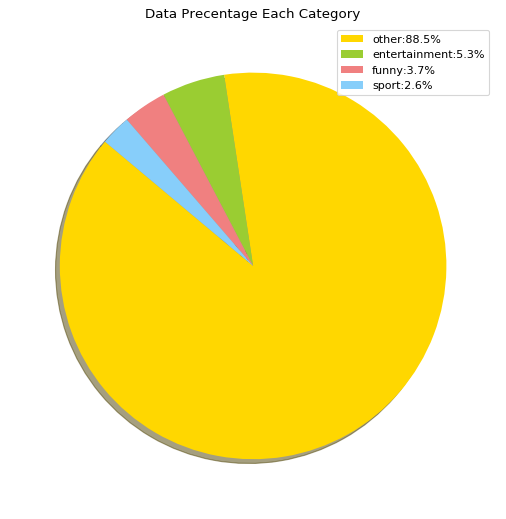

In [45]:
pie_diagram_category(frekuensi, category_name)

## Natural Language Processing

In [0]:
# load stopwords
stopwordsload = drive.CreateFile({'id':'1VR_8-muPKje_GurGDtUuCpwWqPZHnvLH'})
stopwordsload.GetContentFile('stop_words.txt')
with open('stop_words.txt', encoding='UTF-8') as fp:
    stopwords = fp.readlines()
    stopwords = set([x.strip() for x in stopwords])

In [0]:
# Cleaning text
def raw_to_words(raw_text, stop_words=None):
    # 1. Remove HTML
    text_1 = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters with regex
    letters_only = re.sub("[^a-zA-Z]", " ", text_1)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. Remove stop words
    if stop_words:
        meaningful_words = [w for w in words if not w in stop_words]   
    else:
        meaningful_words = words
    
    # 5. Join the words back into one string separated by space & return
    return(" ".join(meaningful_words))

In [0]:
# clean data train
clean_data_train = df_train
clean_data_train['text'] = clean_data_train['text'].apply(raw_to_words, stop_words=stopwords)
clean_data_train = clean_data_train.loc[clean_data_train['text']!='']
# clean data tesing
clean_data_test = df_test
clean_data_test['text'] = clean_data_test['text'].apply(raw_to_words, stop_words=stopwords)
clean_data_test = clean_data_test.loc[clean_data_test['text']!='']

In [49]:
clean_data_train.head()

,category,text
0,other,mantap resep sayur asem non msg
1,other,rontgen foto polos abdomen
2,entertainment,artis ratusan warga jupe peristirahatan terakhir
3,other,september sai bumi pokbal gojek diminta bersatu
4,other,keren banget cara pasang keramik lantai tembok...


In [50]:
clean_data_test.head()

,category,text
0,other,nggak surga wisata
1,other,chicken hoisin sauce
2,other,pasang vilter udara yamaha mio akibatnya ganti...
3,other,new ducati multistrada s gran canaria test photos
4,entertainment,taecyeon pm kejutkan penggemar penampilannya f...


In [51]:
# create category dict for replacing category label from text to numeric
category_dict=dict((v,i+1) for i,v in enumerate(category_name))
category_dict

{'entertainment': 2, 'funny': 3, 'other': 1, 'sport': 4}

In [0]:
# replacing category to be numeric
clean_data_train=clean_data_train.replace({'category':category_dict})
clean_data_test=clean_data_test.replace({"category":category_dict})

In [53]:
print(clean_data_train.head(3))
print(clean_data_test.head(3))

   category                                              text
0         1                   mantap resep sayur asem non msg
1         1                        rontgen foto polos abdomen
2         2  artis ratusan warga jupe peristirahatan terakhir
   category                                               text
0         1                                 nggak surga wisata
1         1                               chicken hoisin sauce
2         1  pasang vilter udara yamaha mio akibatnya ganti...


## Word Could Each Category

In [0]:
def show_wordcloud(data, stop_words, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        #max_words=200,
        max_font_size=80,
        width=400,
        height=300,
        ).generate(str(data))
    fig = plt.figure(1, figsize=(4, 3))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

WORD COULD FOR CATEGORY : OTHER


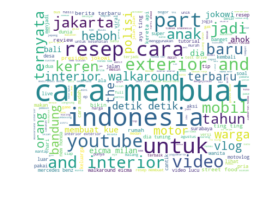

WORD COULD FOR CATEGORY : ENTERTAINMENT


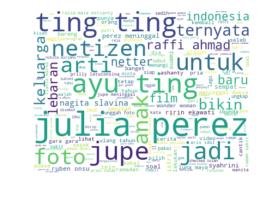

WORD COULD FOR CATEGORY : FUNNY


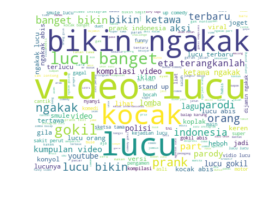

WORD COULD FOR CATEGORY : SPORT


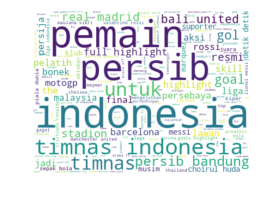

In [55]:
# automate generate wordcloud each category
for i,v in enumerate(category_name):
    print('WORD COULD FOR CATEGORY :',v.upper())
    sample=clean_data_train.loc[clean_data_train['category']==(i+1)]
    big_text=" ".join(list(sample['text']))
    show_wordcloud(big_text, stopwords)

In [56]:
# checking for null value after text preprocessing
print(clean_data_train.isna().sum())
print(clean_data_test.isna().sum())

category    0
text        0
dtype: int64
category    0
text        0
dtype: int64


#CLASSIFICATION PROCESS

In [0]:
# maximum word to be used
MAX_NB_WORDS=5000
# maximum number of word each title
MAX_SQUENCE_LENGTH=100
# word embeding dimension
EMBED_DIM=50

In [58]:
# finding unique word used for modelling from data train and data test
tokenizer=Tokenizer(num_words=MAX_NB_WORDS)
merge1=clean_data_train['text'].values
merge1=np.append(merge1, clean_data_test['text'].values)
tokenizer.fit_on_texts(pd.DataFrame(merge1)[0].values)
word_index=tokenizer.word_index
print('unique word',len(word_index))

unique word 104931


In [0]:
# convert text to be sequence using word_index
X_train=tokenizer.texts_to_sequences(clean_data_train['text'].values)
X_test=tokenizer.texts_to_sequences(clean_data_test['text'].values)

In [0]:
# truncated sequence each text so every text has same length
X_train=pad_sequences(X_train, maxlen=MAX_SQUENCE_LENGTH)
X_test=pad_sequences(X_test, maxlen=MAX_SQUENCE_LENGTH)
# converting categorical data to be vector
Y_train=pd.get_dummies(clean_data_train['category']).values
Y_test=pd.get_dummies(clean_data_test['category']).values

In [61]:
# shape each data and label
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(250116, 100) (62534, 100)
(250116, 4) (62534, 4)


### Create model

In [65]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBED_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Train on 200092 samples, validate on 50024 samples
Epoch 1/10
200092/200092 [==============================] - 373s 2ms/step - loss: 0.2464 - acc: 0.9153 - val_loss: 0.1933 - val_acc: 0.9249
Epoch 2/10
200092/200092 [==============================] - 372s 2ms/step - loss: 0.1796 - acc: 0.9290 - val_loss: 0.1861 - val_acc: 0.9275
Epoch 3/10
200092/200092 [==============================] - 372s 2ms/step - loss: 0.1684 - acc: 0.9322 - val_loss: 0.1862 - val_acc: 0.9275
Epoch 4/10
200092/200092 [==============================] - 373s 2ms/step - loss: 0.1607 - acc: 0.9344 - val_loss: 0.1898 - val_acc: 0.9271
Epoch 5/10
200092/200092 [==============================] - 380s 2ms/step - loss: 0.1555 - acc: 0.9363 - val_loss: 0.1899 - val_acc: 0.9267


In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           250000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 270,404
Trainable params: 270,404
Non-trainable params: 0
_________________________________________________________________


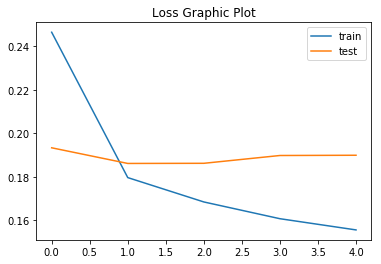

In [67]:
plt.title('Loss Graphic Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

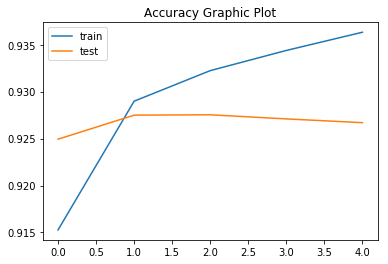

In [68]:
plt.title('Accuracy Graphic Plot')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [69]:
accuracy=model.evaluate(X_test, Y_test)
print('Test using Data Testing : ')
print('Loss : ', accuracy[0])
print('Accuracy : ', accuracy[1])

62534/62534 [==============================] - 30s 472us/step
Test using Data Testing : 
Loss :  0.1845760171612898
Accuracy :  0.9295743115745034


# Test Model With New Article Title

In [0]:
category_dict

{'entertainment': 2, 'funny': 3, 'other': 1, 'sport': 4}

In [0]:
def predict_text(teks):
    teks=[raw_to_words(teks)]
    seq=tokenizer.texts_to_sequences(teks)
    padded=pad_sequences(seq, maxlen=MAX_SQUENCE_LENGTH)
    pred=model.predict(padded)
    for i in category_dict:
      if(category_dict[i]==(np.argmax(pred)+1)):
         return pred, i

In [112]:
print('Input your article titile : ')
teks=input()
print('------------------------result------------------')
print('category result :', predict_text(teks)[1])
print('probability output', predict_text(teks)[0])

Input your article titile : 
Super junior, artis pertama yang hadir sebagai bintang tamu di Indonesia
------------------------result------------------
category result : entertainment
probability output [[3.8061485e-01 6.1613226e-01 4.8854505e-04 2.7642851e-03]]
